In [3]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from xclim.indices import keetch_byram_drought_index as kbdi

## **Trends in wind speed (ERA5)**

In [17]:
sfcWind = xr.open_dataset("data/era5_sfcWind_daily_US_Hawaii.nc").sfcWind

In [28]:
uv_aug = xr.open_dataset("data/adaptor.mars.internal-1692362409.1959784-13120-7-3d824d7c-c444-4328-a12c-b23f47bbc451.nc")
sfcWind_aug = np.sqrt(np.add(np.multiply(uv_aug.u10, uv_aug.u10), np.multiply(uv_aug.v10, uv_aug.v10))).rename("sfcWind")

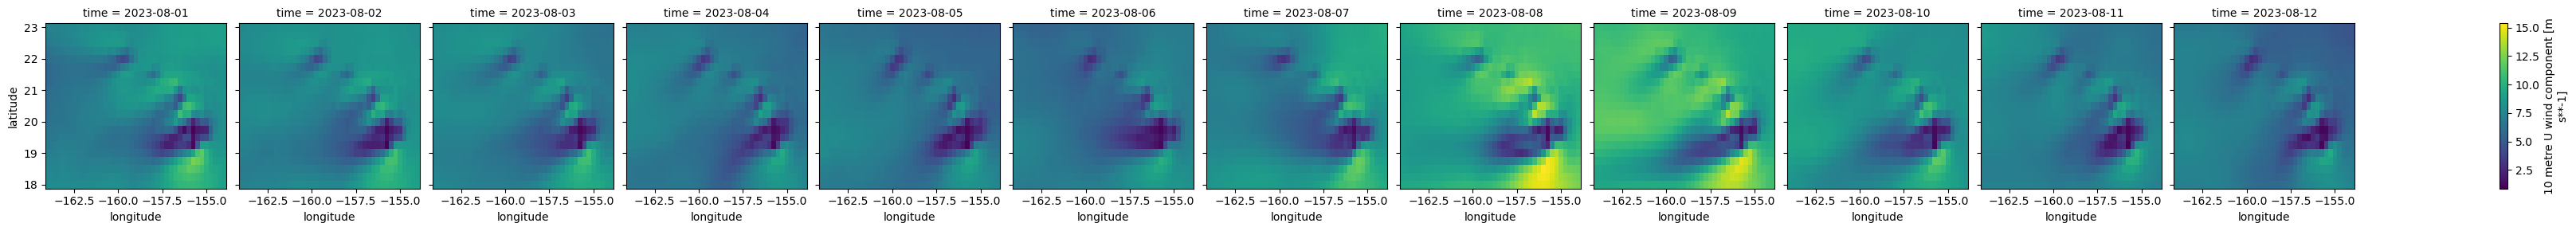

In [33]:
sfcWind_aug.resample(time = "D").mean().plot(col = "time")

In [73]:
ds = xr.open_dataset("data/era5_more-wind-data.nc").resample(time = "D").mean() # swh, fg10, sp
ds.sp.sel(longitude = slice(-165,-150), latitude = slice(25,15)).plot(col = "time", col_wrap = 4)

---
## **Synoptic meteorology**

In [18]:
ds = wrap_lon(xr.open_dataset("data/era5_synoptic_august.nc"))
ds["sfcWind"] = np.sqrt(np.add(np.multiply(ds.u10, ds.u10), np.multiply(ds.v10, ds.v10))).rename("sfcWind")
ds = ds.resample(time = "D").mean()
ds["msl"] = convert_units_to(ds.msl, "hPa")
# ds = ds.sel(longitude = slice(-160,-154), latitude = slice(23,18))
# ds["msl"] = ds.msl - ds.msl.mean("time")

In [54]:
df = pd.read_csv("data/hurricane-dora.txt", sep = "\t", header = None, names = ["date", "time", "lat", "lon", "speed", "low", "cat", "catn"])
df["day"] = [int(d[-2:]) for d in df.date]
df["lon"] = [l if l < 0 else -l for l in df.lon]

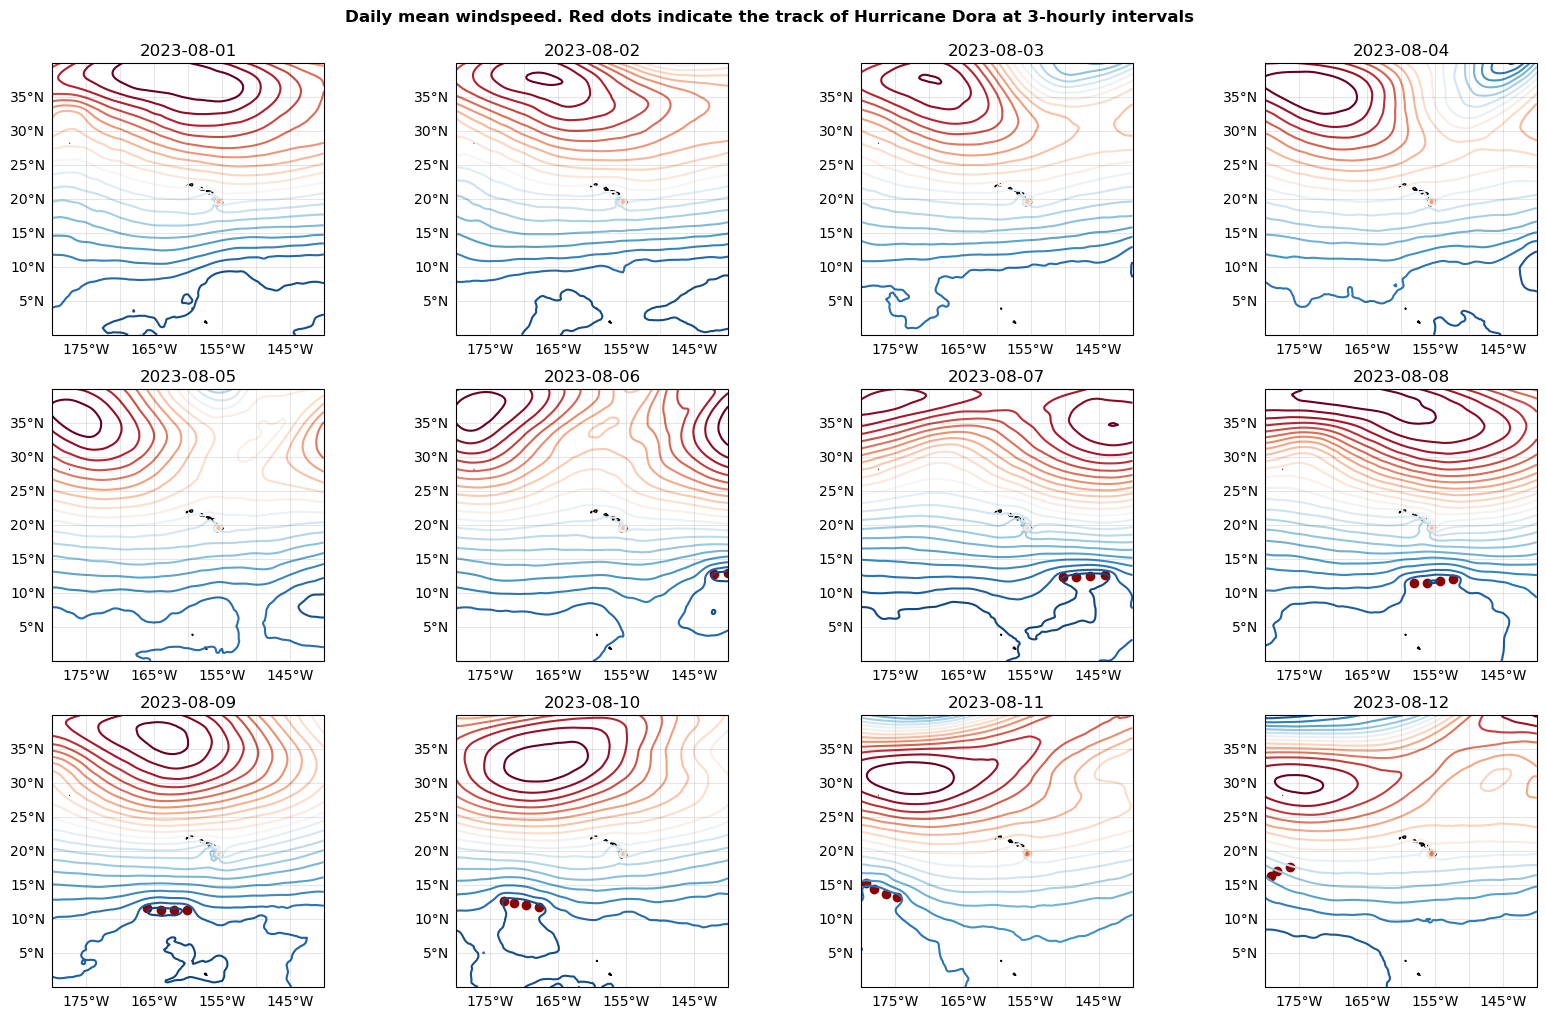

In [66]:
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (20,12), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

for i in range(12):
    
    ax = fig.axes[i]
    
    ds_i = ds.isel(time = i)
    df_i = df.loc[df.day == i+1]
    
    # ds_i.sfcWind.plot(ax = ax)
    cs = ax.contour(ds.longitude, ds.latitude, ds_i.msl, cmap = "RdBu_r", levels = range(int(np.floor(ds_i.msl.min())), int(np.ceil(ds_i.msl.max()))))
    ax.scatter(df_i.lon, df_i.lat, color = "darkred")
    # 
    # ax.clabel(cs)
    # ax.quiver(ds.longitude, ds.latitude, ds_i.u10, ds_i.v10, alpha = 0.5)
    ax.set_title(ds_i.time.dt.date.values)
    
    ax.coastlines()
#     sf.boundary.plot(ax = ax, color = "red", lw = 1)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    ax.set_xlim(-180,-140)
    
    plt.suptitle("Daily mean windspeed. Red dots indicate the track of Hurricane Dora at 3-hourly intervals", fontweight = "bold", y = 0.925)
plt.savefig("fig/event-map_era5_sfcWind.png")

## **Keetch-Byram for Maui**

In [9]:
tp = convert_units_to(xr.open_dataset("../../Downloads/era5_tp_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tp, "mm/day")
tmax = convert_units_to(xr.open_dataset("../../Downloads/era5_tmax_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tmax, "degC").sel(time = tp.time)
tp_annual = convert_units_to(tp.sel(time = slice("1990", "2010")).mean("time"), "mm/year")

In [10]:
kbdi_all = kbdi(tp, tmax, tp_annual)

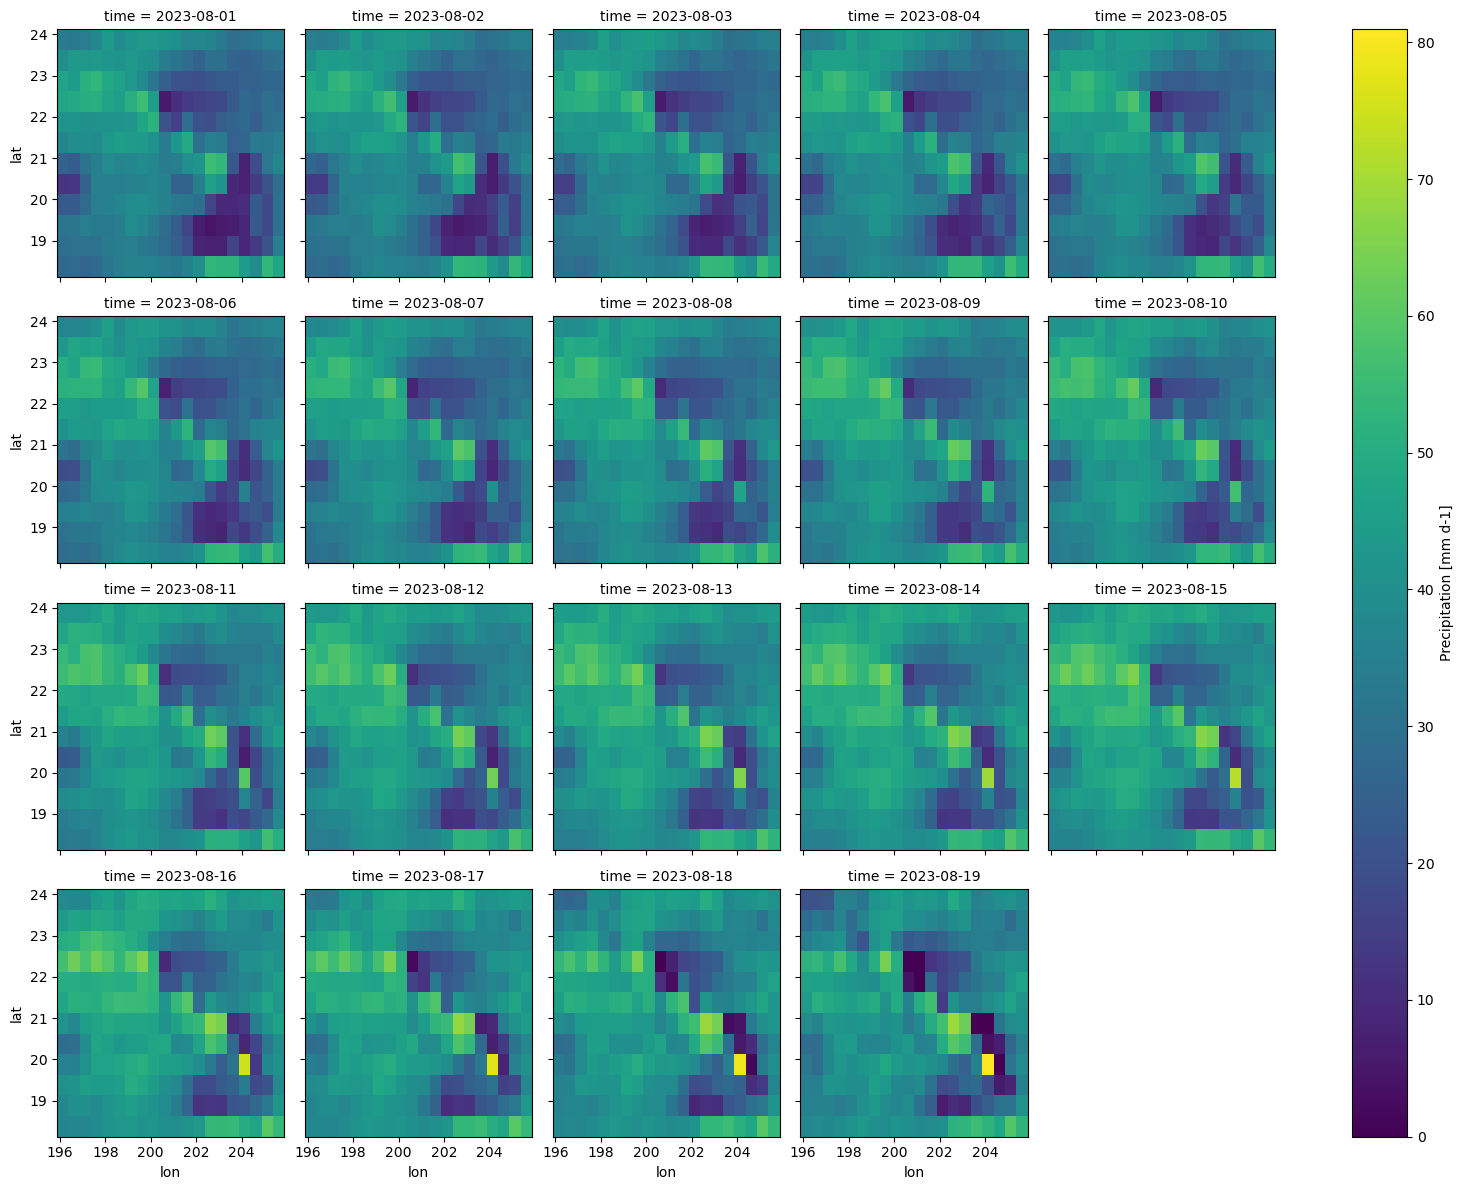

In [13]:
kbdi_all.sel(time = "2023-08").plot(col = "time", col_wrap = 5)

---
---

In [150]:
tp = convert_units_to(xr.open_dataset("../../Downloads/era5_tp_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tp.sel(time = "2022"), "mm/day")
tmax = convert_units_to(xr.open_dataset("../../Downloads/era5_tmax_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tmax.sel(time = "2022"), "degC")
tp_annual = convert_units_to(tp.mean("time"), "mm/year")

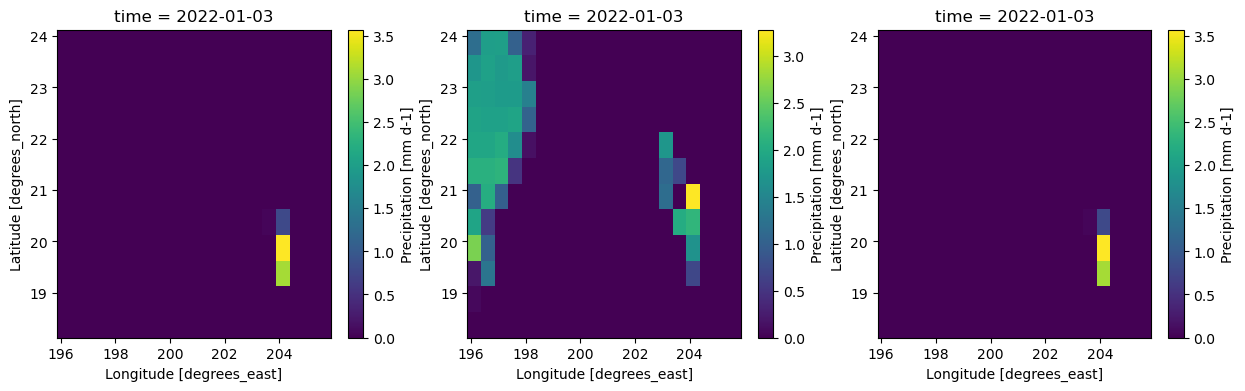

In [73]:
kbdi_2022 = kbdi(pr = tp, tasmax = tmax, pr_annual = tp_annual)

kbdi_d1 = kbdi(pr = tp.isel(time = slice(0,5)), tasmax = tmax.isel(time = slice(0,5)), pr_annual = tp_annual)
kbdi_d2 = kbdi(pr = tp.isel(time = slice(1,5)), tasmax = tmax.isel(time = slice(1,5)), pr_annual = tp_annual)

fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100)
kbdi_d1.isel(time = 2).plot(ax = axs[0])
kbdi_d2.isel(time = 1).plot(ax = axs[1])
kbdi_2022.isel(time = 2).plot(ax = axs[2])

In [5]:
tp = convert_units_to(xr.open_dataset("../../Downloads/era5_tp_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tp, "mm/day")
tmax = convert_units_to(xr.open_dataset("../../Downloads/era5_tmax_daily_extended_-164--154E_18-24N_16Aug23_1400.nc").tmax, "degC").sel(time = tp.time)
tp_annual = convert_units_to(tp.resample(time = "AS-JAN").mean(), "mm/year").mean("time").rename("tp_ann")

In [212]:
kbdi_years = kbdi(pr = tp,tasmax = tmax, pr_annual = tp_annual)

In [198]:
kbdi_years = [xr.zeros_like(tp_annual.isel(time = 0).squeeze(drop = True))]

for y in tp_annual.time.dt.year:
    
    if y == 1950:
        kbdi_years.append(kbdi(pr = tp.sel(time = str(y.values.tolist())),
                               tasmax = tmax.sel(time = str(y.values.tolist())),
                               pr_annual = tp_annual.sel(time = str(y.values.tolist())).squeeze(drop = True)))
    else:
        kbdi_years.append(kbdi(pr = tp.sel(time = str(y.values.tolist())),
                               tasmax = tmax.sel(time = str(y.values.tolist())),
                               pr_annual = tp_annual.sel(time = str(y.values.tolist())).squeeze(drop = True), kbdi0 = kbdi_years[-1].isel(time = -1)))

In [213]:
kbdi_ts = kbdi_years.mean(["lat", "lon"])

kbdi_q95 = kbdi_ts.sel(time = slice(None, "2022")).groupby("time.dayofyear").quantile(0.95).rolling(dayofyear = 7, center = True).mean()

In [214]:
fig, ax = plt.subplots(figsize = (6,4), dpi = 100)

for y in range(1950,2023):
    ts_y = kbdi_ts.sel(time = str(y))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.2)

# add 95th %ile: exceeded by only 4 years from 1941-2022
kbdi_q95.plot(ax = ax, color = "red", alpha = 0.5)

y = 2023
ts_y = kbdi_ts.sel(time = str(y))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", alpha = 1)
    
    # ax.set_xticks(labelticks)
    # ax.set_xticklabels(labels)
    # ax.set_xlim(0,366)
    # ax.set_xlabel("")
    
#     [ax.axvline(x, color = "k", alpha = 0.05) for x in [i+1 for i in range(366) if (days[i].day) == 1]]
   

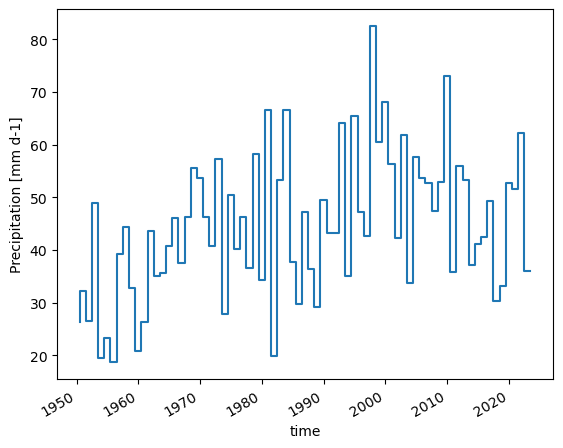

In [217]:
kbdi_ts.resample(time = "QS-JAN").mean().groupby("time.season")["JJA"].plot(drawstyle = "steps") 

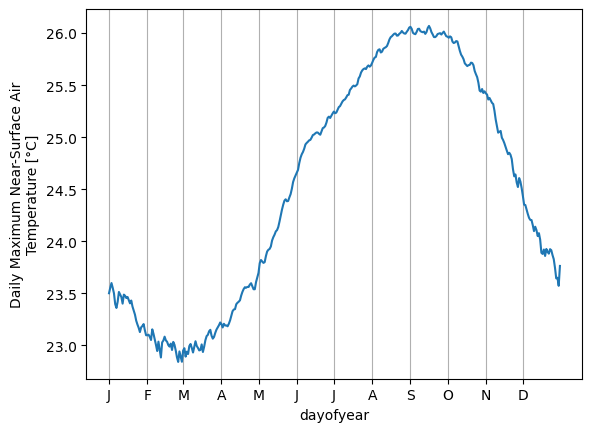

In [9]:
tmax.groupby("time.dayofyear").mean().mean(["lat", "lon"]).plot()

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 1]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 1]

plt.gca().set_xticks(labelticks)
plt.gca().set_xticklabels(labels)
plt.grid(axis = "x")

plt.savefig("fig/seasonal-cycle_tmax.png")

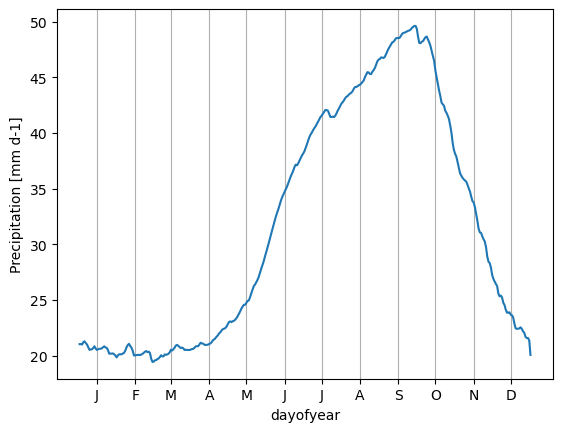

In [223]:
kbdi_ts.groupby("time.dayofyear").mean().plot()

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 1]

plt.gca().set_xticks(labelticks)
plt.gca().set_xticklabels(labels)
plt.grid(axis = "x")

## **Station data**

In [31]:
df = pd.read_csv("data/station_data_pr/2023/08/rainfall_new_day_statewide_partial_station_data_2023_08.csv", index_col = "Station.Name")
df = df.loc[df.Island == "MA"]
sf = gpd.read_file("sf_Maui/")

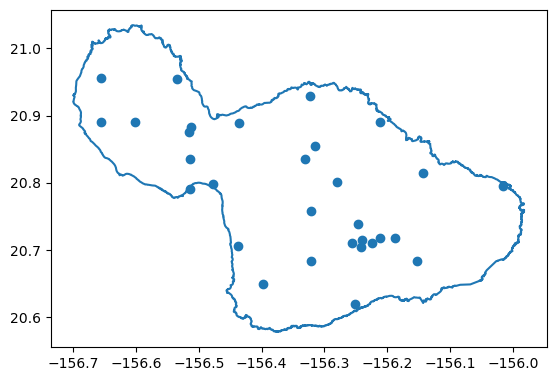

In [32]:
sf.boundary.plot()
ax = plt.gca()
ax.scatter(df.LON, df.LAT)

In [34]:
df.iloc[:,[-1]].transpose()

Station.Name,Ulupalakua Ranch,KepuniGulchRainGage,KAUPO GAP,KULA 1,MAALAEA BAY,Kealia Pond NWR,Kihei 2,Kula Branch Stn,LOWER KAHUKU CS,WestWailuaikiRainGagenrKeanae,...,Kahakuloa,south rim,Sliding Sands,Puu o Pele,Lava lake,Puu Nole,NENE NEST HN-152,SUMMIT HN-153,KAILUA 446,Haiku
X2023.08.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.16,...,0.254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.254482,1.686092


### **Compile data into a single timeseries**

In [78]:
varnm = "pr"

all_data = []
for fnm in sorted(glob.glob("data/station_data_"+varnm+"/*/*/*.csv")):
    
    # load each file, filter just MAUI, choose columns with headers beginning with X, transpose & append to list of data
    df = pd.read_csv(fnm, index_col = "Station.Name")
    df = df.loc[df.Island == "MA", [c[:1] == "X" for c in df.columns]].transpose()
    all_data.append(df)

# cat into single dataframe
all_data = pd.concat(all_data)

# convert index to proper datetime
all_data.index = [datetime(int(s[1:5]), int(s[6:8]), int(s[9:11])) for s in all_data.index]
all_data.to_csv("data/station-data_"+varnm+".csv")

In [ ]:
# get station locations

all_locs = []
for fnm in sorted(glob.glob("data/station_data_pr/*/*/*.csv") + glob.glob("data/station_data_tmax/*/*/*.csv")):
    
    # load each file, filter just Maui, choose last column (which should contain the precip values), transpose & append to list of data
    df = pd.read_csv(fnm, index_col = "Station.Name")
    df = df.loc[df.Island == "MA", ["ELEV.m.", "LON", "LAT"]]
    all_locs.append(df)

In [207]:
elev = pd.concat([l[["ELEV.m."]].transpose() for l in all_locs])
elev = pd.DataFrame({c : elev[c].dropna().max() for c in elev.columns}, index = ["elev"])

lon = pd.concat([l[["LON"]].transpose() for l in all_locs])
lon = pd.DataFrame({c : lon[c].dropna().max() for c in lon.columns}, index = ["lon"])

lat = pd.concat([l[["LAT"]].transpose() for l in all_locs])
lat = pd.DataFrame({c : lat[c].dropna().max() for c in lat.columns}, index = ["lat"])

In [217]:
locs = pd.concat([elev, lon, lat]).transpose()
locs.to_csv("data/station_locations.csv")

### **Find most complete stations**

In [166]:
pr = pd.read_csv("data/station-data_pr.csv", index_col = 0, parse_dates = True)

<AxesSubplot: >

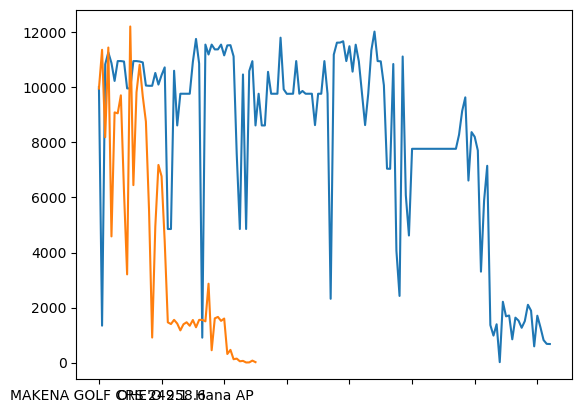

In [167]:
(~np.isnan(pr)).sum(axis = 0).plot()

In [168]:
pr_wholeyears = (~np.isnan(pr)).groupby(pr.index.year).sum() > 360
pr = pr.loc[:,pr_wholeyears.loc[slice(1990, 2015)].sum(axis = 0) == 26] # stations with complete data from 1990-2015
pr.to_csv("data/station-data_pr_1990-2015-complete.csv")

In [188]:
tmax = pd.read_csv("data/station-data_tmax.csv", index_col = 0, parse_dates = True)
tmax_wholeyears = (~np.isnan(tmax)).groupby(tmax.index.year).sum() >= 360
tmax = tmax.loc[:,tmax_wholeyears.sum(axis = 0) >= 10]
tmax.to_csv("data/station-data_tmax_some-whole-years.csv")

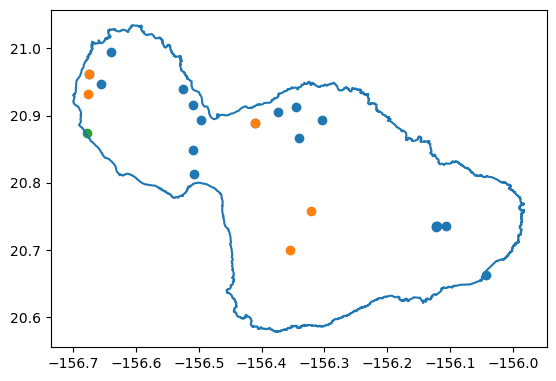

In [229]:
sf = gpd.read_file("sf_Maui/")

sf.boundary.plot()
plt.scatter(locs.loc[pr.columns, "lon"], locs.loc[pr.columns, "lat"])
plt.scatter(locs.loc[tmax.columns, "lon"], locs.loc[tmax.columns, "lat"])
plt.scatter(*get_latlon("Lahaina").values())

In [227]:
get_latlon("Lahaina")

{'lon': -156.677678, 'lat': 20.8738769}

In [230]:
tmax

,KULA HOSPITAL 267,Kula Branch Stn,KAHULUI AIRPORT,PUUKOLII 457.1,KAPALUA W.MAUI AIRPORT 462.4
1990-01-01,20.0,21.1,24.4,NaN,25.6
1990-01-02,20.6,21.1,26.7,NaN,23.9
1990-01-03,18.9,21.1,26.7,NaN,25.0
1990-01-04,20.6,20.0,27.2,NaN,25.6
1990-01-05,20.0,19.4,28.3,NaN,25.6
...,...,...,...,...,...
2023-08-18,NaN,NaN,NaN,NaN,NaN
2023-08-19,NaN,NaN,31.0,NaN,NaN
2023-08-20,NaN,NaN,31.0,NaN,NaN
2023-08-21,NaN,NaN,31.0,NaN,NaN
